In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns


In [32]:
import pandas as pd
import yfinance as yf

# Define your portfolio holdings
# Example format: {'Ticker': ('Sector', Quantity, Purchase Price)}
stock_holdings = {
    'AAPL': ('Technology', 10, 150),
    'MSFT': ('Technology', 5, 200),
    'TSLA': ('Automotive', 8, 300),
    'AMZN': ('E-commerce', 4, 3300),
    'JNJ': ('Healthcare', 7, 160),
}
# Bond holdings: {'Type': (Interest Rate, Maturity Date,Investment)}
bond_holdings = {
    'Corporate Bond': (0.05, '2025-01-01', 10000),  # Example: 10000 is the total investment in the bond
    'Government Bond': (0.03, '2030-01-01', 5000),
}
# Mutual funds: {'Name': (Underlying Assets, Expense Ratio,Invest)}
mutual_funds = {
    'Vanguard 500 Index Fund': ('Stocks', 0.04, 15000),
    'iShares Russell 2000 ETF': ('Small-Cap Stocks', 0.19, 8000),
}
# Example format: {'Ticker': (Quantity, Purchase Price)}
crypto_holdings = {
    'BTC-USD': (2, 30000), #Don't forget to insert the right currency associated
    'ETH-USD': (5, 2000),
}

cash_holdings = {'USD': 1000, 'EUR': 500}  # Add more currencies here

# DataFrames for stocks, bonds, mutual funds, and cryptos
stock_df = pd.DataFrame(stock_holdings).T
stock_df.columns = ['Sector', 'Quantity', 'Purchase Price']

bond_df = pd.DataFrame(bond_holdings).T
bond_df.columns = ['Interest Rate', 'Maturity Date', 'Investment']

mutual_fund_df = pd.DataFrame(mutual_funds).T
mutual_fund_df.columns = ['Underlying Assets', 'Expense Ratio', 'Investment']

crypto_df = pd.DataFrame(crypto_holdings).T
crypto_df.columns = ['Quantity', 'Purchase Price']

# Fetch current market prices for stocks and cryptocurrencies
def get_current_price(ticker):
    try:
        return yf.Ticker(ticker).info['currentPrice']
    except:
        return None

stock_prices = {ticker: get_current_price(ticker) for ticker in stock_holdings}
crypto_prices = {crypto: get_crypto_price(crypto) for crypto in crypto_holdings}

# Update DataFrames with current prices
stock_df['Current Price'] = stock_df.index.map(stock_prices)
crypto_df['Current Price'] = crypto_df.index.map(crypto_prices)

# Calculate P&L and Annualized Returns for Stocks and Cryptos
average_holding_period_years = 3
for df in [stock_df, crypto_df]:
    df['P&L'] = (df['Current Price'] - df['Purchase Price']) * df['Quantity']
    df['Annualized Return'] = ((1 + df['P&L'] / (df['Purchase Price'] * df['Quantity'])) ** (1 / average_holding_period_years)) - 1

# Portfolio Volatility (Standard Deviation of Returns)
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
monthly_returns = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change() for ticker in stock_holdings})
portfolio_volatility = monthly_returns.std().mean()  # Simplified average volatility

# Total Portfolio Value
stock_df['Total Value'] = stock_df['Current Price'] * stock_df['Quantity']
crypto_df['Total Value'] = crypto_df['Current Price'] * crypto_df['Quantity']
total_stock_crypto_value = stock_df['Total Value'].sum() + crypto_df['Total Value'].sum()
total_bond_mutual_fund_value = bond_df['Investment'].sum() + mutual_fund_df['Investment'].sum()
total_cash_value = sum(cash_holdings.values())
total_portfolio_value = total_stock_crypto_value + total_bond_mutual_fund_value + total_cash_value

# Output some metrics
print("Stock Holdings:\n", stock_df)
print("\nCrypto Holdings:\n", crypto_df)
print("\nBond Holdings:\n", bond_df)
print("\nMutual Fund Holdings:\n", mutual_fund_df)
print("\nPortfolio Volatility (Monthly Returns Standard Deviation):", portfolio_volatility)
print("Total Portfolio Value:", total_portfolio_value)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Stock Holdings:
           Sector Quantity Purchase Price  Current Price       P&L  \
AAPL  Technology       10            150         192.53     425.3   
MSFT  Technology        5            200         376.04     880.2   
TSLA  Automotive        8            300         248.48   -412.16   
AMZN  E-commerce        4           3300         151.94 -12592.24   
JNJ   Healthcare        7            160         156.74    -22.82   

     Annualized Return Total Value  
AAPL          0.086765      1925.3  
MSFT       

In [33]:
##### PERFORMANCE ANALYSIS
# Portfolio Volatility (Standard Deviation of Returns)
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
monthly_returns = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change() for ticker in stock_holdings})

# Calculate equal-weighted portfolio returns for simplicity
portfolio_returns = monthly_returns.mean(axis=1)

# Define Risk-Free Rate and Market Benchmark
risk_free_rate = 0.01  # Example: 1% annual rate
benchmark_ticker = 'SPY'  # Example: S&P 500 ETF

# Fetch and process benchmark data
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

# Calculate Excess Returns
excess_returns = monthly_returns.subtract(risk_free_rate / 12, axis=0)

# Sharpe Ratio
sharpe_ratio = excess_returns.mean() / excess_returns.std()
sharpe_ratio_annual = (12**0.5) * sharpe_ratio

# Sortino Ratio
negative_volatility = excess_returns[excess_returns < 0].std()
sortino_ratio = excess_returns.mean() / negative_volatility
sortino_ratio_annual = (12**0.5) * sortino_ratio


# Print Metrics
print("Annual Sharpe Ratio:", sharpe_ratio_annual.mean())
print("Annual Sortino Ratio:", sortino_ratio_annual.mean())


# Align portfolio returns and benchmark data
aligned_data = pd.concat([portfolio_returns, benchmark_data], axis=1).dropna()
aligned_portfolio_returns = aligned_data.iloc[:, 0]
aligned_benchmark_returns = aligned_data.iloc[:, 1]

# Calculate Covariance and Variance
covariance_matrix = np.cov(aligned_portfolio_returns, aligned_benchmark_returns)
portfolio_benchmark_covariance = covariance_matrix[0, 1]
benchmark_variance = covariance_matrix[1, 1]

# Calculate Beta
beta = portfolio_benchmark_covariance / benchmark_variance

# Recalculate Alpha with corrected Beta
expected_portfolio_return = risk_free_rate + beta * (aligned_benchmark_returns.mean() - risk_free_rate)
alpha = (aligned_portfolio_returns.mean() - risk_free_rate) - beta * (aligned_benchmark_returns.mean() - risk_free_rate)

# Print Beta and Alpha
print("Portfolio Beta:", beta)
print("Portfolio Alpha:", alpha)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Annual Sharpe Ratio: 0.8918715262417953
Annual Sortino Ratio: 2.017566247258666
Portfolio Beta: 0.6905080687971161
Portfolio Alpha: 0.03656658642885386


In [34]:
#STOCK ANALYSIS
# Portfolio Volatility (Standard Deviation of Returns)
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
monthly_returns = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change() for ticker in stock_holdings})

# Calculate various financial metrics
volatility = monthly_returns.std() * np.sqrt(12)  # Annualize the monthly volatility
total_return = (monthly_returns + 1).prod() - 1
number_of_years = monthly_returns.shape[0] / 12
annualized_return = (1 + total_return) ** (1 / number_of_years) - 1

# Maximum Drawdown and Recovery Time:
cumulative_returns = (1 + monthly_returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
# Recovery time calculation would depend on identifying specific drawdown and recovery periods

# Diversification Metrics (Correlation):
correlation_matrix = monthly_returns.corr()

# Value at Risk (VaR):
confidence_level = 0.05
var = norm.ppf(confidence_level, monthly_returns.mean(), monthly_returns.std())

# Expense Ratios:
expense_ratios = {'FundName': 0.05}  # Example: 5% expense ratio

# Liquidity Ratio and Cash Position:
cash_total = sum(cash_holdings.values())  # Correct way to sum the values in the cash_holdings dictionary
cash_position = cash_total / total_portfolio_value

# Print out the calculated metrics
print("Volatility:", volatility)
print("Total Return:", total_return)
print("Annualized Return:", annualized_return)
print("Maximum Drawdown:", max_drawdown)
print("Correlation Matrix:\n", correlation_matrix)
print("Value at Risk (VaR):", var)
print("Expense Ratios:", expense_ratios)
print("Cash Position:", cash_position)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Volatility: AAPL    0.298431
MSFT    0.219934
TSLA    0.767149
AMZN    0.330508
JNJ     0.170881
dtype: float64
Total Return: AAPL     4.086639
MSFT     2.898784
TSLA    10.199519
AMZN     1.023209
JNJ      0.390590
dtype: float64
Annualized Return: AAPL    0.377114
MSFT    0.306918
TSLA    0.608422
AMZN    0.148695
JNJ     0.067015
dtype: float64
Maximum Drawdown: AAPL   -0.264042
MSFT   -0.305285
TSLA   -0.677190
AMZN   -0.520968
JNJ    -0.148162
dtype: float64
Correlation Matrix:
           AAPL      MSFT      TSLA      AMZN       JNJ
AAPL  1.000000  0.730179  0.697322  0.720527  0.454874
MSFT  0.730179  1.000000  0.538131  0.670340  0.381143
T

In [35]:
# Calculate Monthly Returns for Stocks and Cryptocurrencies
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
stock_monthly_returns = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change() for ticker in stock_holdings})
crypto_monthly_returns = pd.DataFrame({crypto: yf.download(crypto, start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change() for crypto in crypto_holdings})

# Combine Stock and Crypto Returns
combined_returns = pd.concat([stock_monthly_returns, crypto_monthly_returns], axis=1)

# Calculate Portfolio Metrics
portfolio_volatility = combined_returns.std() * np.sqrt(12)  # Annualize the monthly volatility
portfolio_total_return = (combined_returns + 1).prod() - 1
number_of_years = combined_returns.shape[0] / 12
portfolio_annualized_return = (1 + portfolio_total_return) ** (1 / number_of_years) - 1

# Maximum Drawdown and Recovery Time:
cumulative_returns = (1 + combined_returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Diversification Metrics (Correlation):
correlation_matrix = combined_returns.corr()

# Value at Risk (VaR):
confidence_level = 0.05
var = norm.ppf(confidence_level, combined_returns.mean(), combined_returns.std())

# Expense Ratios (Assuming this is static data)
expense_ratios = {'FundName': 0.05}  # Example: 5% expense ratio

# Liquidity Ratio and Cash Position:
cash_total = sum(cash_holdings.values())
cash_position = cash_total / total_portfolio_value

# Print out the calculated metrics
print("Portfolio Volatility:", portfolio_volatility.mean())
print("Portfolio Total Return:", portfolio_total_return.mean())
print("Portfolio Annualized Return:", portfolio_annualized_return.mean())
print("Portfolio Maximum Drawdown:", max_drawdown.min())
print("Portfolio Correlation Matrix:\n", correlation_matrix)
print("Portfolio Value at Risk (VaR):", var.mean())
print("Expense Ratios:", expense_ratios)
print("Cash Position:", cash_position)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Volatility: 0.4895352542136518
Portfolio Total Return: 6.463608193033857
Portfolio Annualized Return: 0.4104218831412802
Portfolio Maximum Drawdown: -0.7695555075981503
Portfolio Correlation Matrix:
              AAPL      MSFT      TSLA      AMZN       JNJ   BTC-USD   ETH-USD
AAPL     1.000000  0.730179  0.697322  0.720527  0.454874  0.277676  0.357184
MSFT     0.730179  1.000000  0.538131  0.670340  0.381143  0.386504  0.409418
TSLA     0.697322  0.538131  1.000000  0.604677  0.280429  0.361143  0.48

In [36]:
# Concentration Risk:
asset_values = stock_df['Total Value']  # Include bonds, mutual funds, and cryptos if available
portfolio_total_value = asset_values.sum()
concentration_risk = asset_values / portfolio_total_value

# Dividend Yield:
# Update this with actual dividend data for your stocks
annual_dividends = {'AAPL': 0.85, 'MSFT': 2.48, 'TSLA': 0.00, 'AMZN': 0.00, 'JNJ': 4.04}  # Example dividends
dividend_yield = {ticker: annual_dividends.get(ticker, 0) / stock_prices.get(ticker, 1)
                  for ticker in stock_holdings}

# Recovery Time from Maximum Drawdown:
# This requires identifying specific periods of drawdown and recovery
# A loop or a custom function would be needed to calculate this
# DO IT LATER

# Treynor Ratio:
treynor_ratio = excess_returns / beta

# Benchmark Comparison:
benchmark_annual_return = benchmark_data.mean() * 12  # Annualize benchmark return
comparison = annualized_return - benchmark_annual_return

# Value at Risk (VaR) and Conditional Value at Risk (CVaR):
confidence_level = 0.05
var = norm.ppf(confidence_level, monthly_returns.mean(), monthly_returns.std())

# Calculate CVaR for each asset
cvar = monthly_returns[monthly_returns.lt(var)].mean()

# Print out the calculated metrics
print("Concentration Risk:\n", concentration_risk)
print("Dividend Yield:\n", dividend_yield)
print("Treynor Ratio:", treynor_ratio.mean())
print("Benchmark Comparison:", comparison.mean())
print("Conditional Value at Risk (CVaR):\n", cvar)


Concentration Risk:
 AAPL    0.256766
MSFT    0.250751
TSLA    0.265106
AMZN    0.081053
JNJ     0.146324
Name: Total Value, dtype: object
Dividend Yield:
 {'AAPL': 0.004414896379784969, 'MSFT': 0.0065950430805233485, 'TSLA': 0.0, 'AMZN': 0.0, 'JNJ': 0.025775169069797117}
Treynor Ratio: AAPL    0.043789
MSFT    0.034814
TSLA    0.089181
AMZN    0.022211
JNJ     0.008492
dtype: float64
Benchmark Comparison: 0.2936660653883385
Conditional Value at Risk (CVaR):
 AAPL   -0.120541
MSFT   -0.104567
TSLA   -0.367334
AMZN   -0.237525
JNJ    -0.081617
dtype: float64


In [37]:
# Printing each metric
print("Portfolio Analysis Metrics:")

print("\nTotal and Annualized Returns:")
print("Total Return:", total_return)
print("Annualized Return:", annualized_return)

print("\nRisk Metrics:")
print("Volatility (Standard Deviation):", volatility)
print("Beta:", beta)
print("Value at Risk (VaR):", var)
print("Conditional Value at Risk (CVaR):", cvar)

print("\nRisk-Adjusted Return Metrics:")
print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)
print("Treynor Ratio:", treynor_ratio)

print("\nDiversification Metrics:")
print("Correlation Matrix:\n", correlation_matrix)
print("Concentration Risk:\n", concentration_risk)

print("\nDividend Yield:")
print("Dividend Yields:", dividend_yield)

print("\nBenchmark Comparison:")
print("Performance Relative to Benchmark:", comparison)

print("\nLiquidity and Cash Position:")
# Assuming liquidity ratio calculation
print("Cash Position:", cash_position)

print("\nExpense Ratios:")
print("Expense Ratios:", expense_ratios)

Portfolio Analysis Metrics:

Total and Annualized Returns:
Total Return: AAPL     4.086639
MSFT     2.898784
TSLA    10.199519
AMZN     1.023209
JNJ      0.390590
dtype: float64
Annualized Return: AAPL    0.377114
MSFT    0.306918
TSLA    0.608422
AMZN    0.148695
JNJ     0.067015
dtype: float64

Risk Metrics:
Volatility (Standard Deviation): AAPL    0.298431
MSFT    0.219934
TSLA    0.767149
AMZN    0.330508
JNJ     0.170881
dtype: float64
Beta: 0.6905080687971161
Value at Risk (VaR): [-0.11063352 -0.07955792 -0.30185067 -0.14076401 -0.07444205]
Conditional Value at Risk (CVaR): AAPL   -0.120541
MSFT   -0.104567
TSLA   -0.367334
AMZN   -0.237525
JNJ    -0.081617
dtype: float64

Risk-Adjusted Return Metrics:
Sharpe Ratio: AAPL    0.350977
MSFT    0.378639
TSLA    0.278068
AMZN    0.160751
JNJ     0.118870
dtype: float64
Sortino Ratio: AAPL    0.783546
MSFT    0.780571
TSLA    0.800865
AMZN    0.317006
JNJ     0.230119
dtype: float64
Treynor Ratio:                 AAPL      MSFT      TS

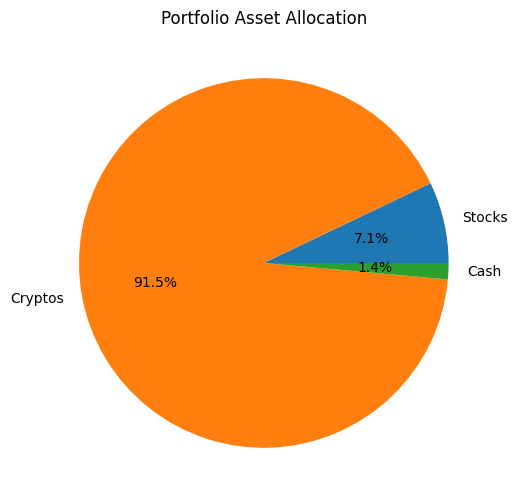

In [38]:
###### PLOTTING
# Plot 1: Asset Allocation Pie Chart
asset_classes_values = [stock_df['Total Value'].sum(),
                        # Add total values for bonds and mutual funds if available
                        crypto_df['Total Value'].sum(),
                        sum(cash_holdings.values())]
asset_classes_labels = ['Stocks', 'Cryptos', 'Cash']  # Add 'Bonds', 'Mutual Funds' as needed
plt.figure(figsize=(10, 6))
plt.pie(asset_classes_values, labels=asset_classes_labels, autopct='%1.1f%%')
plt.title('Portfolio Asset Allocation')
plt.show()

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  1 of 1 completed


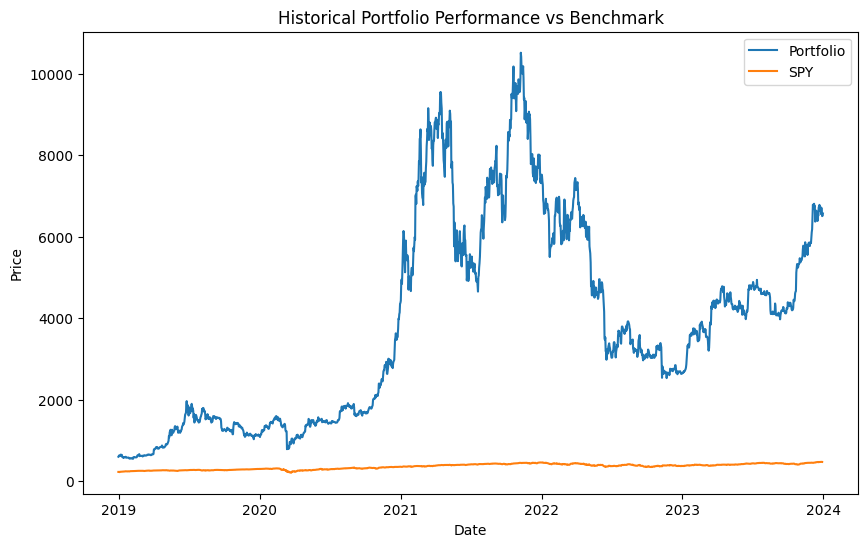

In [39]:
# Plot 2: Historical Performance compared to Benchmark
# Fetch historical data for the entire portfolio (assuming equal weights for simplicity)
portfolio_tickers = list(stock_holdings.keys()) + list(crypto_holdings.keys())
historical_data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close'].fillna(method='ffill')
portfolio_performance = historical_data.mean(axis=1)  # Simplified average performance
benchmark_performance = yf.download(benchmark_ticker, start=start_date, end=end_date)['Adj Close'].fillna(method='ffill')
plt.figure(figsize=(10, 6))
plt.plot(portfolio_performance.index, portfolio_performance, label='Portfolio')
plt.plot(benchmark_performance.index, benchmark_performance, label=benchmark_ticker)
plt.title('Historical Portfolio Performance vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

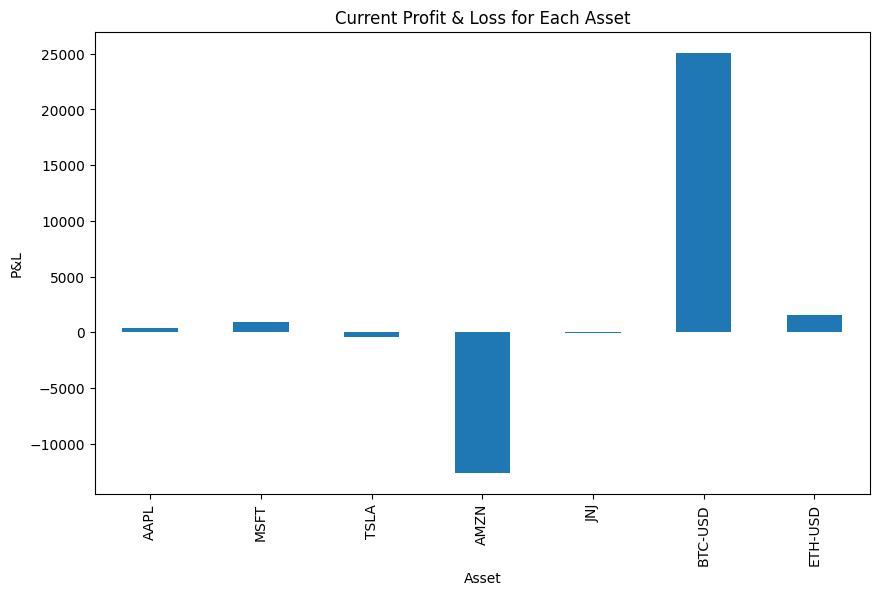

In [40]:
# Plot 3: Current P&L for Each Asset
pnl_data = pd.concat([stock_df['P&L'], crypto_df['P&L']])  # Combine P&L for stocks and cryptos
plt.figure(figsize=(10, 6))
pnl_data.plot(kind='bar')
plt.title('Current Profit & Loss for Each Asset')
plt.xlabel('Asset')
plt.ylabel('P&L')
plt.show()

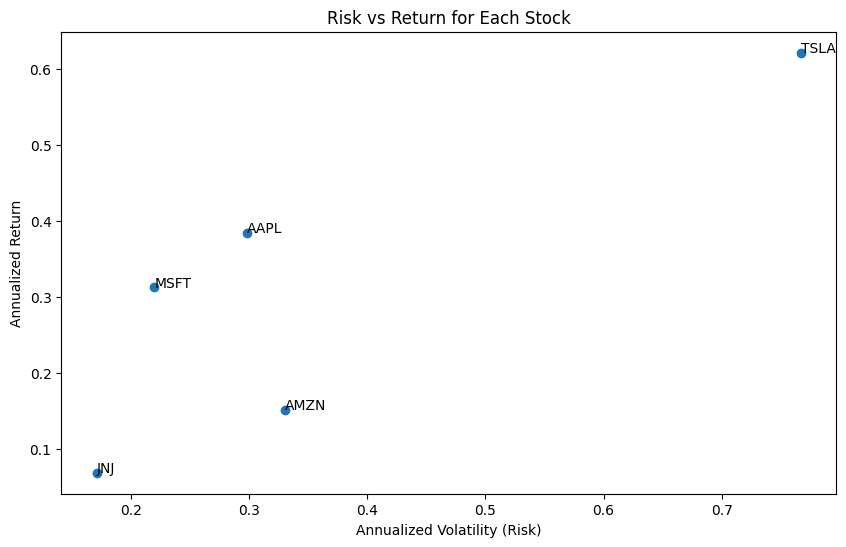

In [41]:
# Plot 4: Risk vs Return for Each Stock
# Annualized Volatility and Returns
annualized_volatility = monthly_returns.std() * np.sqrt(12)
annualized_returns = (monthly_returns + 1).prod() ** (12 / monthly_returns.count()) - 1
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatility, annualized_returns)
for i, txt in enumerate(annualized_volatility.index):
    plt.annotate(txt, (annualized_volatility[i], annualized_returns[i]))
plt.title('Risk vs Return for Each Stock')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.show()

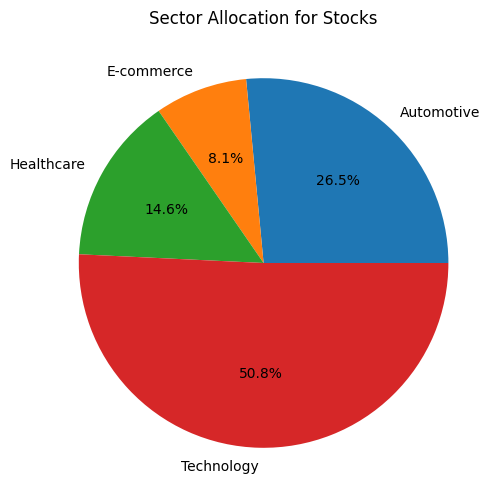

In [42]:
# Plot 5: Sector Allocation for Stocks
sector_values = stock_df.groupby('Sector')['Total Value'].sum()
plt.figure(figsize=(10, 6))
sector_values.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sector Allocation for Stocks')
plt.ylabel('')
plt.show()

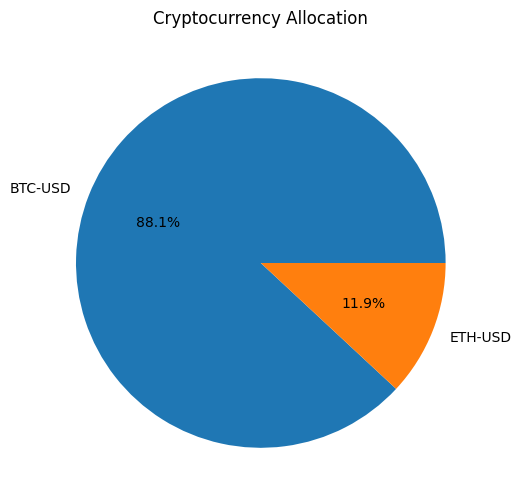

In [43]:
# Plot 6: Cryptocurrency Allocation
plt.figure(figsize=(10, 6))
crypto_df['Total Value'].plot(kind='pie', labels=crypto_df.index, autopct='%1.1f%%')
plt.title('Cryptocurrency Allocation')
plt.ylabel('')
plt.show()

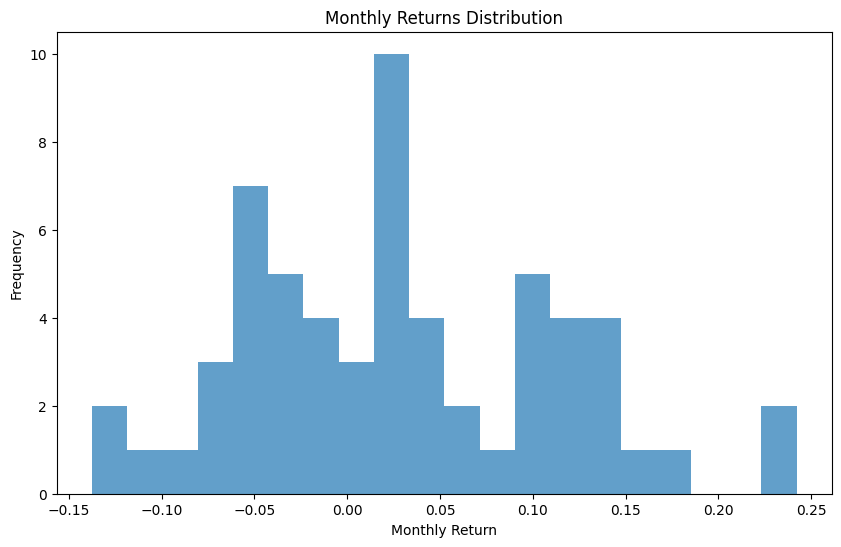

In [44]:
# Plot 7: Monthly Returns Distribution for Portfolio
portfolio_monthly_returns = monthly_returns.mean(axis=1)  # Assuming equal weights for simplicity
plt.figure(figsize=(10, 6))
plt.hist(portfolio_monthly_returns, bins=20, alpha=0.7)
plt.title('Monthly Returns Distribution')
plt.xlabel('Monthly Return')
plt.ylabel('Frequency')
plt.show()

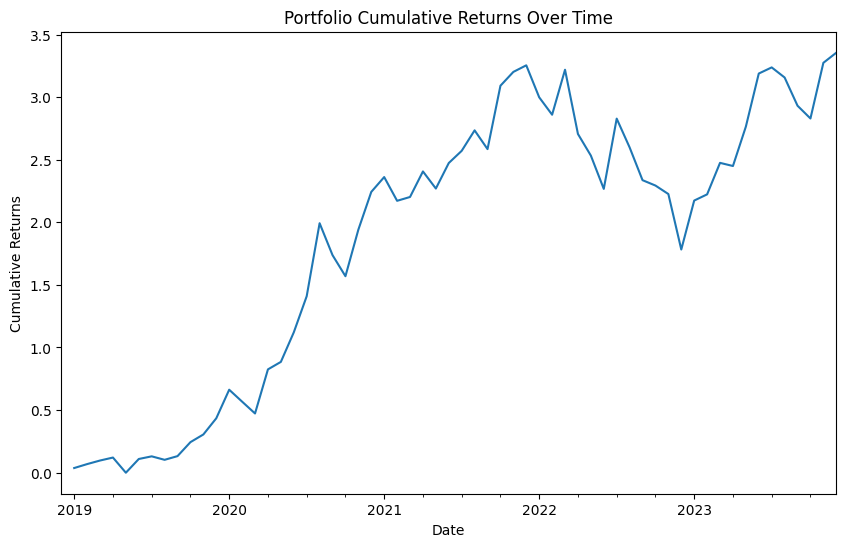

In [45]:
# Plot 8: Portfolio Cumulative Returns Over Time
cumulative_returns = (1 + portfolio_monthly_returns).cumprod() - 1
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

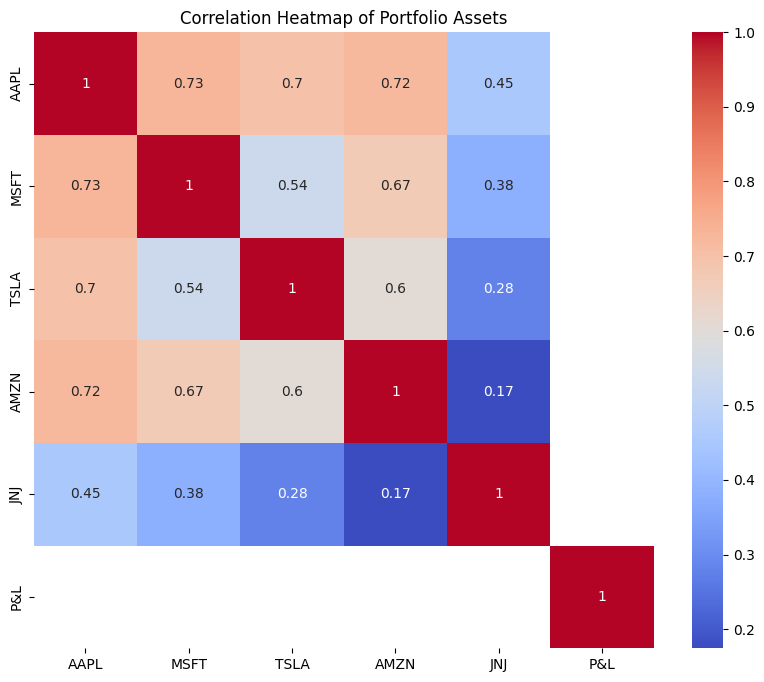

In [46]:
# Plot 9: Correlation Heatmap of Assets in the Portfolio
combined_returns = pd.concat([monthly_returns, crypto_df['P&L']], axis=1)  # Assuming P&L as a proxy for crypto returns
correlation_matrix = combined_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Portfolio Assets')
plt.show()

<Figure size 1000x600 with 0 Axes>

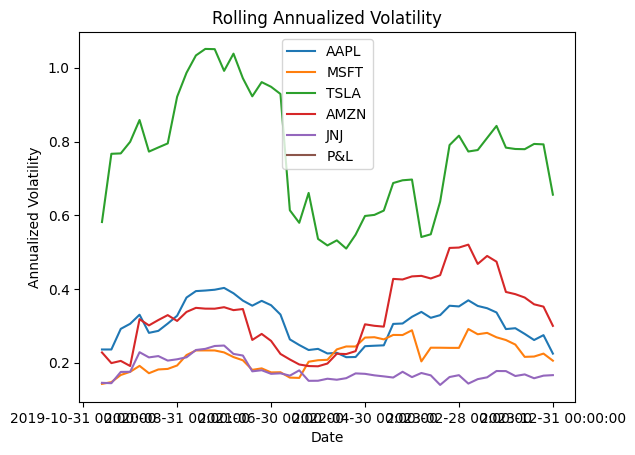

In [47]:
# Plot 10: Rolling Annualized Volatility
rolling_volatility = combined_returns.rolling(window=12).std() * np.sqrt(12)
plt.figure(figsize=(10, 6))
rolling_volatility.plot()
plt.title('Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

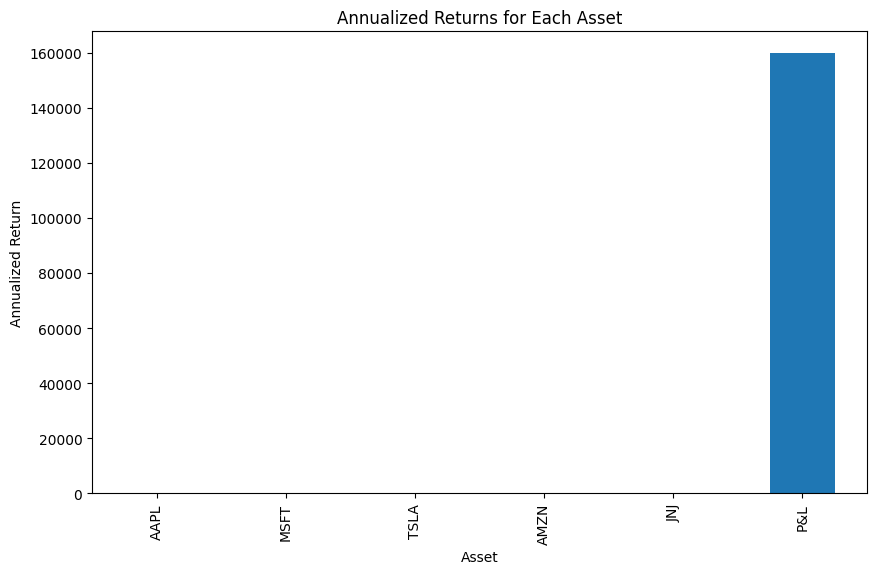

In [48]:
# Plot 11: Bar Plot of Annualized Returns for Each Asset
annualized_returns = combined_returns.mean() * 12
plt.figure(figsize=(10, 6))
annualized_returns.plot(kind='bar')
plt.title('Annualized Returns for Each Asset')
plt.xlabel('Asset')
plt.ylabel('Annualized Return')
plt.show()

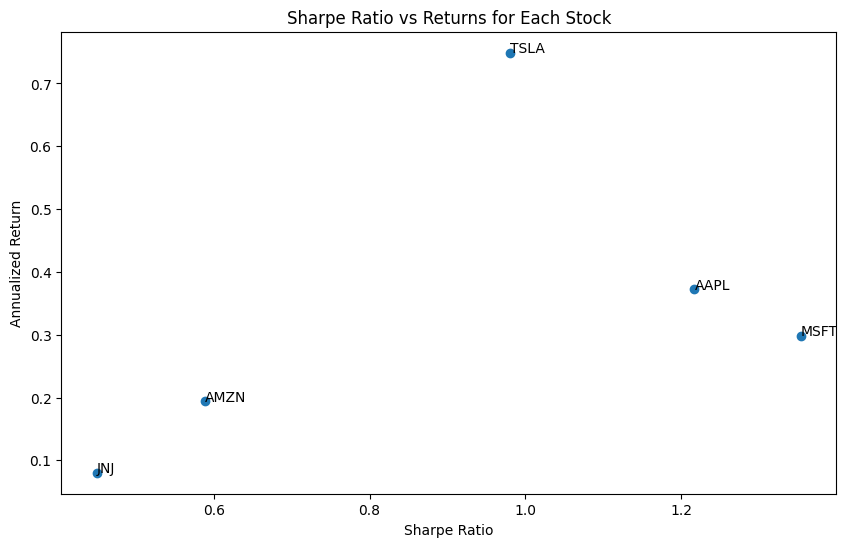

In [49]:
# Plot 12: Sharpe Ratio vs Returns for Each Stock
# Assuming risk_free_rate is defined
sharpe_ratios = annualized_returns / rolling_volatility.mean()
plt.figure(figsize=(10, 6))
plt.scatter(sharpe_ratios, annualized_returns)
for i, txt in enumerate(sharpe_ratios.index):
    plt.annotate(txt, (sharpe_ratios[i], annualized_returns[i]))
plt.title('Sharpe Ratio vs Returns for Each Stock')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Annualized Return')
plt.show()

<Figure size 1200x600 with 0 Axes>

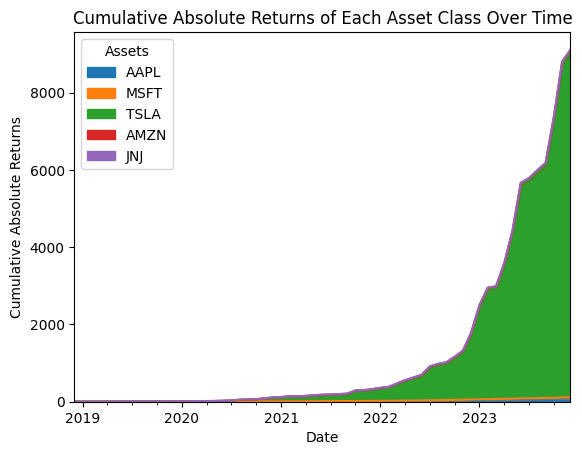

In [50]:
# Plot 13: Stacked Area Plot of Cumulative Returns of Each Asset Class
cumulative_absolute_returns = (1 + abs(monthly_returns)).cumprod() - 1

plt.figure(figsize=(12, 6))
cumulative_absolute_returns.plot(kind='area', stacked=True)
plt.title('Cumulative Absolute Returns of Each Asset Class Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Absolute Returns')
plt.legend(title='Assets')
plt.show()

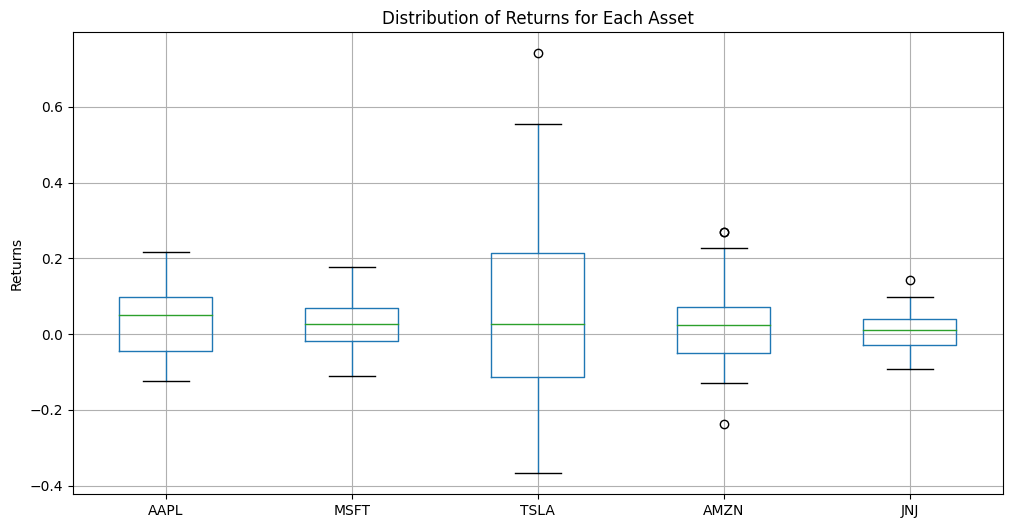

In [51]:
# Plot 14: Box Plot of Returns for Each Asset
plt.figure(figsize=(12, 6))
monthly_returns.boxplot()
plt.title('Distribution of Returns for Each Asset')
plt.ylabel('Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

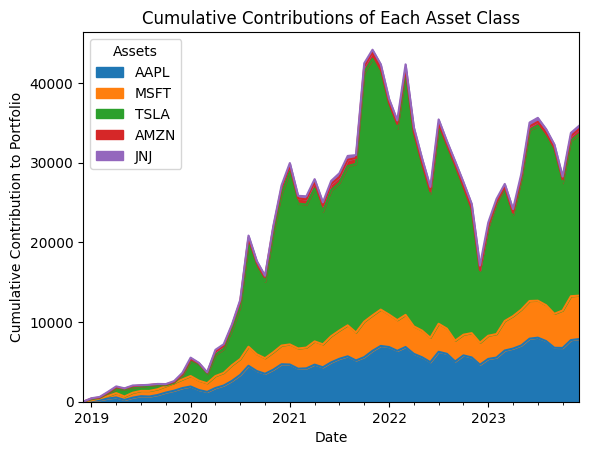

In [52]:
# Plot 15: Cumulative Contributions of Each Asset Class
cumulative_returns_by_asset = (1 + monthly_returns).cumprod() - 1
# Use absolute values for contributions
abs_cumulative_contributions = np.abs(cumulative_returns_by_asset) * stock_df['Total Value']

plt.figure(figsize=(12, 6))
abs_cumulative_contributions.plot(kind='area', stacked=True)
plt.title('Cumulative Contributions of Each Asset Class')
plt.xlabel('Date')
plt.ylabel('Cumulative Contribution to Portfolio')
plt.legend(title='Assets')
plt.show()


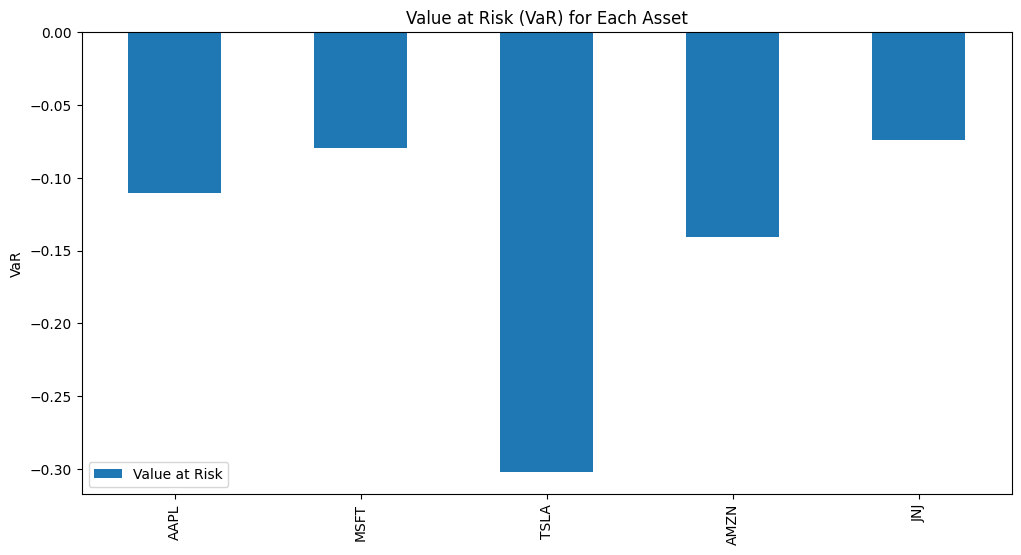

In [53]:
# Plot 16: Value at Risk (VaR) for Each Asset
confidence_interval = 0.05
var_values = norm.ppf(confidence_interval, monthly_returns.mean(), monthly_returns.std())
var_series = pd.Series(var_values, index=monthly_returns.columns)

plt.figure(figsize=(12, 6))
var_series.plot(kind='bar')
plt.title('Value at Risk (VaR) for Each Asset')
plt.ylabel('VaR')
plt.legend(['Value at Risk'])
plt.show()

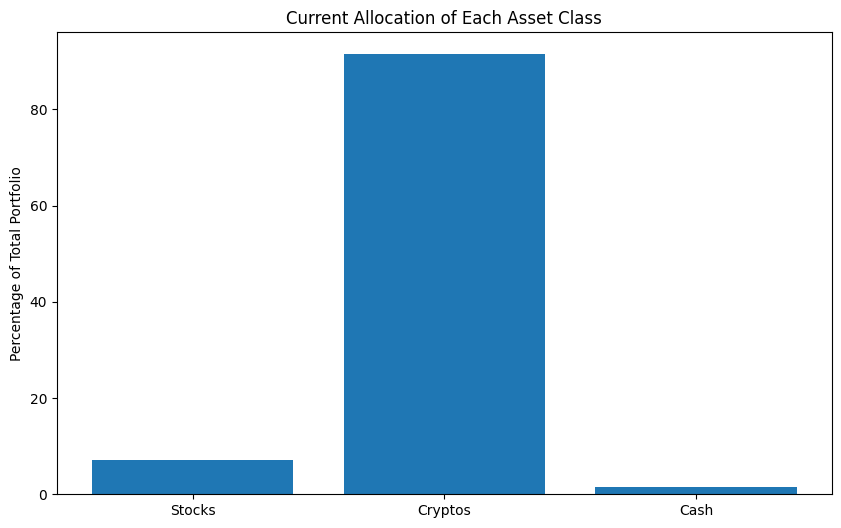

In [54]:
# Plot 17: Current Allocation of Each Asset Class as Percentage of Total Portfolio
total_values_by_asset = {'Stocks': stock_df['Total Value'].sum(),
                         'Cryptos': crypto_df['Total Value'].sum(),
                         # Include other asset classes like bonds and mutual funds if available
                         'Cash': sum(cash_holdings.values())}
total_portfolio_value = sum(total_values_by_asset.values())
allocation_percentages = {k: v / total_portfolio_value * 100 for k, v in total_values_by_asset.items()}
plt.figure(figsize=(10, 6))
plt.bar(allocation_percentages.keys(), allocation_percentages.values())
plt.title('Current Allocation of Each Asset Class')
plt.ylabel('Percentage of Total Portfolio')
plt.show()

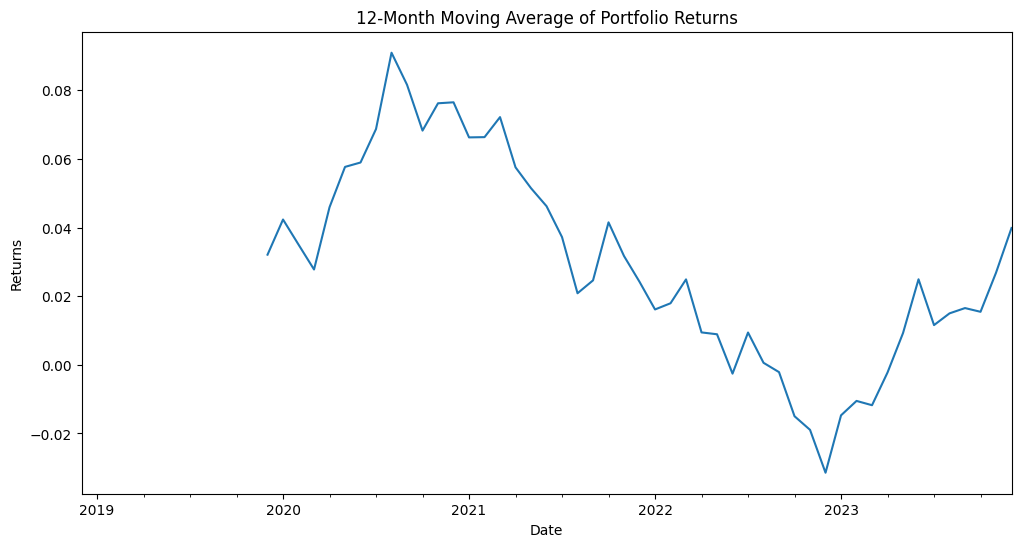

In [55]:
# Plot 18: Moving Average of Portfolio Returns
moving_average = portfolio_returns.rolling(window=12).mean()
plt.figure(figsize=(12, 6))
moving_average.plot()
plt.title('12-Month Moving Average of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

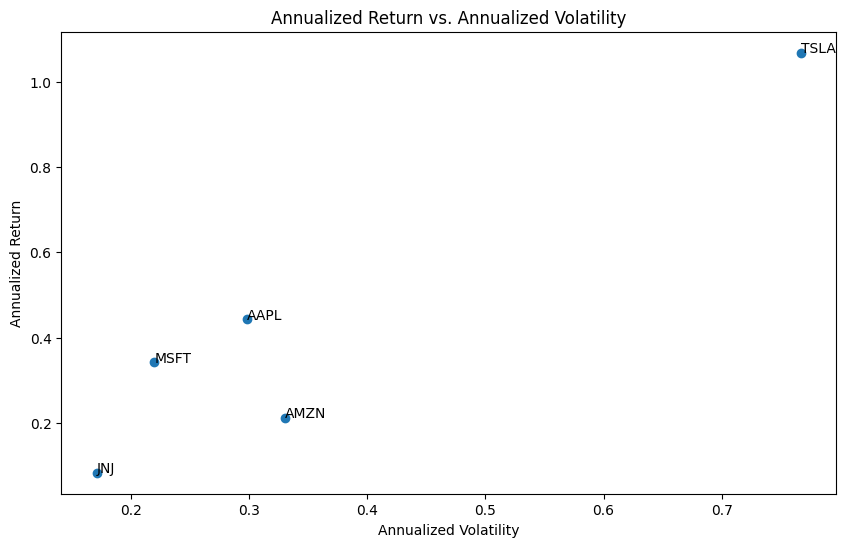

In [56]:
# Plot 19: Scatter Plot of Annualized Return vs. Annualized Volatility
annualized_volatility = monthly_returns.std() * np.sqrt(12)
annualized_return = (monthly_returns.mean() + 1).pow(12) - 1
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatility, annualized_return)
for i, txt in enumerate(annualized_volatility.index):
    plt.annotate(txt, (annualized_volatility[i], annualized_return[i]))
plt.title('Annualized Return vs. Annualized Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.show()

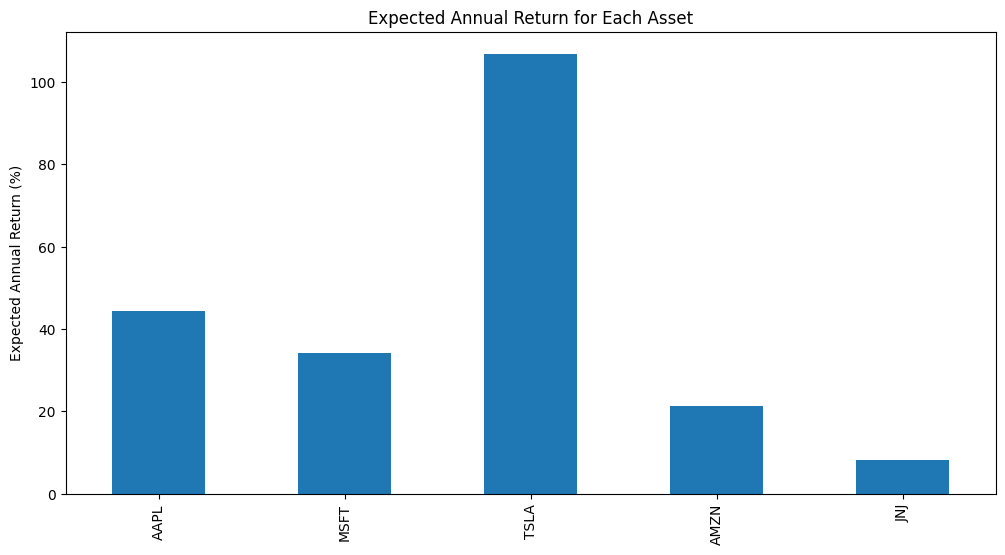

In [57]:
# Plot 20: Expected Annual Return for Each Asset
expected_annual_return = annualized_return * 100  # Convert to percentage
plt.figure(figsize=(12, 6))
expected_annual_return.plot(kind='bar')
plt.title('Expected Annual Return for Each Asset')
plt.ylabel('Expected Annual Return (%)')
plt.show()